# Historsiche Simulation versus Varianz-Kovarianz-Methode

© Thomas Robert Holy 2019
<br>
Version 0.9.1

## Voraussetzungen:

- Wenn ihr an dieser Stelle angelangt seid, ist bereits alles vorbereitet 
<br>
- Das Notebook lässt sich bereits vollständig mit künstlich generierten Aktienkurse ausführen

### Optional:

Um ein Portfolio aus echten Aktienkursen zusammenzustellen, könnt Ihr im Home-Verzeichnis bis zu fünf .csv-Datein hochladen. Diese sollten die folgenden Kritieren erfüllen:
<br>
- Sie umfassen alle denselben Zeitraum
<br>
- Es wird ein Punkt zur Dezimaltrennung verwendet
<br>
- Es wird ein Komma zur Spaltentrennung verwendet

## Grundlegende Einstellungen:

Zunächst müssen die notwendigen Packete (auch Module) importiert werden, damit auf diese zugegriffen werden kann.

In [16]:
import numpy as np # Programmbibliothek die eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays ermöglicht
import pandas as pd #  Programmbibliothek die Hilfsmittel für die Verwaltung von Daten und deren Analyse anbietet
import matplotlib.pyplot as plt # Programmbibliothek die es erlaubt mathematische Darstellungen aller Art anzufertigen
import matplotlib.patches as mpatches
import operator # Programmbibliothek die Ausgabe in diesem Beispiel übersichtlicher gestaltet
import datetime as dt # Das datetime-Modul stellt Klassen bereit, mit denen Datums- und Uhrzeitangaben auf einfache und komplexe Weise bearbeitet werden können
import sys # Dieses Modul bietet Zugriff auf einige Variablen, die vom Interpreter verwendet oder verwaltet werden, sowie auf Funktionen, die stark mit dem Interpreter interagieren
from scipy import stats # SciPy ist ein Python-basiertes Ökosystem für Open-Source-Software für Mathematik, Naturwissenschaften und Ingenieurwissenschaften. 

Anschließend definieren wir die Einstellungen mit denen die Ausgaben generiert werden sollen.
Hierfür nutzen wir das zuvor importierte Modul `operator`.
Zusätzlich erhöhen wir noch die Displaybreite für das DataFrame, welches wir später verwenden werden und modifizieren die Größe der Grafik, welche später angezeigt werden soll.

In [17]:
SCREEN_WIDTH = 114 # Definiert die maximale Breite der Ausgabe, d.h. wie viele Zeichen die Ausgabe maximal umfasst
centered = operator.methodcaller('center', SCREEN_WIDTH) # Definiert die Variable "centered", welche die Ausgabe zentriert 

pd.set_option('display.width', 1000) # Erhöht die Displaybreite für DataFrames, sodass mehr Spalten nebeneinander angezeigt werden können
plt.rcParams["figure.figsize"] = 10,7.5 # Parameter für die Größe der Grafik

Ein Beispiel:

In [18]:
print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Die Ausgabe wird nun zentriert um die Übersichtlichkeit zu verbessern.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

#------------------------------------------------------------------------------------------------------------------#
|                  [INFO] Die Ausgabe wird nun zentriert um die Übersichtlichkeit zu verbessern.                   | 
#------------------------------------------------------------------------------------------------------------------#


## Datensätze einlesen und manipulieren:

Nun wollen wir Datensätze einlesen.
Da Jupityer Notebook leider Eingaben nicht zeilenweise einlesen kann, müssen wir die Datensätze manuell definieren und anschließend zum Array "dateinamen" hinzufügen.
Standardmäßig werden zunächst zwei Datensätze (BAS.DE, FME.DE) definiert und im Array "dateinamen" gespeichert.
<br><br>
Hinweis: An dieser Stelle könnt ihr alternativ eure eigenen Datensätze einbringen, indem ihr example1 z.B. in BAS.DE und example2 z.B. in VOW3.DE umbenennt, sofern ihr den entsprechenden Datensatz im Home-Verzeichnis hochgeladen habt.

In [22]:
datensatz1 = 'example1'
datensatz2 = 'example2'

#---------------------------------------------
# Hier könnt ihr weitere Datensätze definieren

#datensatz3 = ''
#datensatz4 = ''
#datensatz5 = ''

#---------------------------------------------
# Diese müssen ggf. noch in diesem Array
# ergänzt werden

dateinamen = [datensatz1,datensatz2]

Nun möchten wir aus den eingelesen Datensätzen den Aktienkurs zum jeweiligen Tag extrahieren. 
Diesen Schritt können wir in Jupyter Notebook automatisieren, indem wir zunächst die leere Liste "kurse" anlegen und anschließend für jeden Eintrag in der Liste "dateinamen" die jeweiligen Spalten "Date" und "Adj Close" einlesen.
Dabei separieren wir die verschiedenen Spalten des jeweiligen Datensatzes mit jedem Komma und interpreteren Punkte als Zeichen für die Dezimaltrennung. Dann fügen wir die Daten zum Array "kurse" hinzu.

In [23]:
kurse = []        

for eintrag in dateinamen:
    kurs = pd.read_csv(str(eintrag) + '.csv',
                sep=',',
                decimal='.',
                usecols=['Date','Adj Close'])
    kurse.append(kurs)

Nun nutzen wir das Modul `datetime` um die Datumsspalte des jeweiligen Datensatzes bearbeitbar zu machen.
Zudem teilen wir dem Programm mit, dass die Einträge der Spalte "Adj Close" numerisch sind und wir mit ihnen rechnen können. Kommt es zu Fehlern werden entsprechende Werte als NaN-Werte zurückgebenen.


In [24]:
for eintrag in kurse:
    eintrag['Date'] = pd.to_datetime(eintrag['Date'])
    eintrag['Adj Close'] = pd.to_numeric(eintrag['Adj Close'], errors='coerce')

## Dataframe erzeugen und Daten zusammentragen:

Jetzt tragen wir die eingelesenen Daten in einem Dataframe zusammen, wobei wir auf das Modul `Pandas` zurückgreifen.
Ein Dataframe kann als Tabelle verstanden werden, welche sich ähnlich wie die in Excel verhält.
Diesen Vorgang können wir wieder automatisieren, damit wir die einzelnen Spalten nicht manuell hinzufügen müssen. 
Zunächst wird das leere DataFrame "kurschart" definiert, anschließend wird für jeden Eintrag in dem Array "kurse" zunächst der entsprechende Aktienkurs und anschließend die dazugehörige Rendte berechnet und zum Dataframe hinzugefügt.
Damit wir die Aktienkurse und Renditen auseinander halten können, greifen wir auf die Dateinamen aus dem Array "dateinamen" zurück.

In [25]:
kurschart = pd.DataFrame()
zaehler = 0

for eintrag in kurse:
    x = dateinamen[zaehler]
    kurschart['Aktienkurs ' + str(x)] = eintrag['Adj Close']
    kurschart['Rendite ' + str(x)] = (eintrag['Adj Close'] - eintrag['Adj Close'].shift(periods=-1)) / eintrag['Adj Close'].shift(periods=-1)
    zaehler += 1

Um die Portfolio-Rendite zu ermitteln, selektieren wir die Spalten des DataFrames "kurschart" indem wir jede zweite Spalte auswählen (dies sind die jeweiligen Rendite-Spalten) und in einem zweiten DataFrame ("hilfs_dataframe") abspeichern. 
Anschließend bilden wir aus sämtlichen selektierten Spalten die Summe und teilen durch die Anzahl der Datensätze, die sich im Array "dateinamen" befinden.

In [26]:
hilfs_dataframe = kurschart.iloc[:, 1::2]
hilfs_dataframe['PF-Rendite'] = hilfs_dataframe.sum(axis = 1, skipna = True) / len(dateinamen)

Diese Portfolio-Rendite fügen wir nun dem urpsrünglichen Dataframe "kurschart" hinzu. 
Zudem erweitern wir den DataFrame und eine Datumsspalte und verwenden diese gleichzeitig als Index.

In [27]:
kurschart['Rendite-PF'] = hilfs_dataframe['PF-Rendite']

kurschart['Datum'] = eintrag['Date']
kurschart = kurschart.set_index('Datum')

Nun lassen wir uns den Dataframe ausgeben:

In [29]:
print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Das Dataframe mit den Aktienkursen der Datensätze und deren jeweiligen Rendite ergibt sich wie folgt: ') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')
print(kurschart)
print('#------------------------------------------------------------------------------------------------------------------#')

#------------------------------------------------------------------------------------------------------------------#
|  [INFO] Das Dataframe mit den Aktienkursen der Datensätze und deren jeweiligen Rendite ergibt sich wie folgt:    | 
#------------------------------------------------------------------------------------------------------------------#
            Aktienkurs example1  Rendite example1  Aktienkurs example2  Rendite example2  Rendite-PF
Datum                                                                                               
2018-01-01               81.450          0.024851               48.780         -0.424798   -0.199974
2018-02-01               79.475          0.127305               84.805          0.232094    0.179699
2018-03-01               70.500         -0.194516               68.830         -0.028579   -0.111548
2018-04-01               87.525          0.128627               70.855         -0.078369    0.025129
2018-05-01               77.550         -0

## Portfolio-Renditedaten bereinigen und analysieren:

Da wir für unsere Simulationsverfahren fortan die Portfolio-Rendite benötigen, speichern wir diese zunächst in einer Liste und führen anschließend eine Bereinigung (um NaN-Werte) durch.

In [30]:
values_PF = kurschart['Rendite-PF'].values.tolist()
values_PF = np.array(values_PF)
values_PF = values_PF[np.logical_not(np.isnan(values_PF))]

Jetzt ermitteln wir den Erwartungswert aus den Portfolio-Renditedaten. Dazu nutzen wir das Modul `Numpy` und lassen uns den so ermittelten Erwartungswert anschließend ausgeben.

In [32]:
mu_PF = np.mean(values_PF)

print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. ' + str(mu_PF) + '.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

#------------------------------------------------------------------------------------------------------------------#
|                 [INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. 0.007146102967529755.                 | 
#------------------------------------------------------------------------------------------------------------------#


Äquivalent verfahren wir mit der Standardabweichung.

In [33]:
std_PF = np.std(values_PF)

print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Das Porfolio hat somit eine Standardabweichung i.H.v. ' + str(std_PF) + '.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

#------------------------------------------------------------------------------------------------------------------#
|                [INFO] Das Porfolio hat somit eine Standardabweichung i.H.v. 0.09296443448891611.                 | 
#------------------------------------------------------------------------------------------------------------------#


In [34]:
mu = mu_PF # Erwartungsawert
sigma = std_PF # Standardabweichung

Um den Start- und Endwert beider Simulationsverfahren sinnvoll zu begrenzen, ermitteln wir den kleinsten und größten Rendite-Wert der im DataFrame "kurschart" vorhanden ist.

In [35]:
mini_values_PF = min(values_PF) # Minimum aus den PF-Realisationen
maxi_values_PF = max(values_PF) # Maximum aus den PF-Realisationen

## Abfragefunktion definieren:

Nun definieren wir eine nützliche Funktion mit deren Hilfe wir die Granularität der jeweiligen Verteilungsfunktion bestimmen können.
Standardmäßig wird die höchste Granularität gewählt, d.h. jede einzelne Realsation wird einzeln erfasst, sodass die Verteilungsfunktion eine sehr hohe Genauigkeit aufweist.
Dies muss jedoch nicht immer sinnvoll sein, weshalb wir diese in einem gewissen Umfang auch selbst bestimmen wollen.
Im Grunde fragt uns die Funktion ob eine Anpassung vorgenommen werden soll oder nicht und wenn ja, welche. 
Im Falle das eine Anpassung vorgenommen wird, wird eine Eingabe erwartet, welche dann weitergeleitet wird.

In [36]:
def abfrage():
    abfrage = None
    while abfrage not in ('Ja', 'Nein', 'ja', 'nein', 'j', 'n'):
        abfrage = input('|' + centered('[EINGABE] Möchten Sie die Granularität anpassen? Geben Sie "Ja" oder "Nein" ein: ') + '| ')        
        if abfrage == 'Nein' or abfrage == 'nein' or abfrage == 'n':
            return len(values_PF)
        elif abfrage == 'Ja' or abfrage == 'ja' or abfrage == 'j':
            return int(input('|' + centered('[EINGABE] Geben sie eine Zahl zwischen ' + str(round(len(values_PF)/10)) + ' und ' + str(len(values_PF)) + ' ein') + '| '))    
        else:
            print('|' + centered('[WARNUNG] Geben Sie "Ja" oder "Nein" ein! ') + '| ')

## Verteilungsfunktionen definieren und plotten:

Im letzten Schritt gilt es nun alle Informationen zusammenzutragen und die beiden Verteilungsfunktionen zu zeichnen.

#------------------------------------------------------------------------------------------------------------------#
|                [EINGABE] Möchten Sie die Granularität anpassen? Geben Sie "Ja" oder "Nein" ein:                  | n
#------------------------------------------------------------------------------------------------------------------#


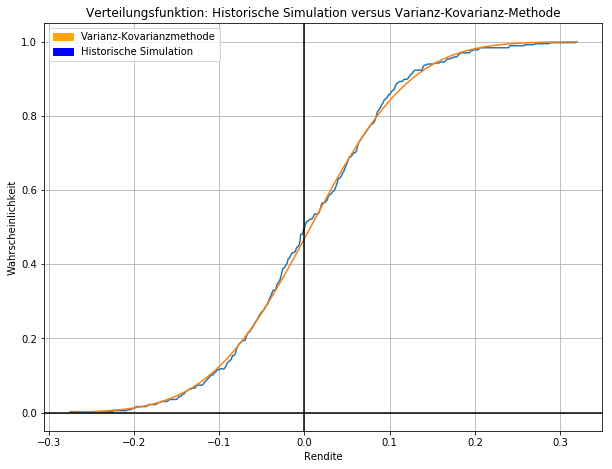

In [37]:
# Funktion aufrufen
print('#------------------------------------------------------------------------------------------------------------------#')
bins = abfrage()
print('#------------------------------------------------------------------------------------------------------------------#')

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Historische Simulation

H, X1 = np.histogram(values_PF, bins, density=True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Varianz-Kovarianz-Methode

x = np.linspace(mini_values_PF, maxi_values_PF, bins) #len(values_PF)) # Erzeuge eine Range vom Minimum der PF-Realisationen bis zum Maximum
#x = np.linspace(mini_values_PF, maxi_values_PF, len(values_PF)) # Erzeuge eine Range vom Minimum der PF-Realisationen bis zum Maximum
plt.plot(x, stats.norm.cdf(x, mu, sigma)) # Plotte die Verteilungfunkton für diese Range mit den geschätzten Parametern aus dem Datensatz

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Weitere Einstellungen der Grafik

plt.grid() # Zeichne ein Gitternetz
plt.xlabel('Rendite') # Beschrifte die x-Achse 
plt.ylabel('Wahrscheinlichkeit') # Beschrifte die y-Achse 
blue_patch = mpatches.Patch(color='blue', label='Historische Simulation') # Lege den Legendeneintrag für die historische Simulation manuell an
orange_patch = mpatches.Patch(color='orange', label='Varianz-Kovarianzmethode')  # Lege den Legendeneintrag für die Varianz-Kovarianz-Methode manuell an
plt.legend(handles=[orange_patch, blue_patch]) # Füge die Legende zur Grafik hinzu
plt.title('Verteilungsfunktion: Historische Simulation versus Varianz-Kovarianz-Methode') # Beschriftung der Grafik
plt.axhline(0, color='black') # Zeichne die x-Achse
plt.axvline(0, color='black') # Zeiche die y-Achse
plt.show() # Zeige die gesamte Grafik